In [1]:
import dill
import gzip
import json
from tqdm import tqdm
from collections import defaultdict
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

sas_file = "./results/BERT4rec.steam/steam_benchmark_2023_01_22T15_57_49/checkpoints/SASRec-vanilla.dill.gz"
gsasrec_file_256_1 = "./results/BERT4rec.steam/steam_benchmark_2023_01_22T15_57_49/checkpoints/DebSASRec-samples:256-t:1.0.dill.gz"
gsasrec_file_128_05 = "./results/BERT4rec.steam/steam_benchmark_2023_01_22T15_57_49/checkpoints/DebSASRec-samples:128.dill.gz"

In [49]:
sas_file = "./results/BERT4rec.ml-1m/ml1m_bert4rec_ft_2023_01_19T13_31_40/checkpoints/SASRec-vanilla.dill.gz"
gsasrec_file_256_1 = "./results/BERT4rec.ml-1m/ml1m_bert4rec_ft_2023_01_19T13_31_40/checkpoints/DebSASRec-samples:256-t:1.0.dill.gz"
gsasrec_file_128_05 = "./results/BERT4rec.ml-1m/ml1m_bert4rec_ft_2023_01_19T13_31_40/checkpoints/DebSASRec-samples:128.dill.gz"

In [50]:
model_sas = dill.load(gzip.open(sas_file)).recommender
model_gsas256_1 = dill.load(gzip.open(gsasrec_file_256_1)).recommender
model_gsas128_05 = dill.load(gzip.open(gsasrec_file_128_05)).recommender

Keras model archive loading:
File Name                                             Modified             Size
variables.h5                                   2023-01-19 18:46:46      4327048
metadata.json                                  2023-01-19 18:46:46           64
config.json                                    2023-01-19 18:46:46          734
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...embedding_dropout
......vars
...item_embeddings_layer
......vars
.........0
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......dense_5
.........vars
............0
............1
......dense_6
.........vars
............0
............1
......dense_7
.........vars
............0
............1
......dense_8
.........vars
............0
........

In [51]:
#sas_predictions_file = "./results/BERT4rec.steam/steam_benchmark_2023_01_22T15_57_49/predictions/SASRec-vanilla.json.gz"
sas_predictions_file = "/home/alekspet/Projects/aprec/aprec/evaluation/results/BERT4rec.ml-1m/ml1m_bert4rec_ft_2023_01_19T13_31_40/predictions/SASRec-vanilla.json.gz"
sas_predictions = json.load(gzip.open(sas_predictions_file, 'r'))

In [52]:
test_actions = {}
for user in sas_predictions[:6040]:
    test_action = json.loads(user['test_actions'][0])
    user_id = test_action['user_id']
    item_id = test_action['item_id']
    test_actions[user_id] = item_id

In [53]:
truth_score_sas = []
truth_score_gsas_256 = []
truth_score_gsas_128 = []

predictions_sas = []
predictions_gsas_256 = []
predictions_gsas_128 = []

import math
def sigmoid(score):
    return 1/(math.exp(-score) + 1)

def get_truth_score(recs, item_id):
    for item, score in recs:
        if item == item_id:
            return sigmoid(score)
    raise Exception("score not found")
    
def get_all_scores(recs):
    result = []
    for rec in recs:
        result.append(sigmoid(rec[1]))
    return result

all_recs_sas = defaultdict(list)
all_recs_gsas_128 = defaultdict(list)
all_recs_gsas_256 = defaultdict(list)


for user in tqdm(list(test_actions.keys())):
    all_recs_sas[user] = model_sas.recommend(user, limit=3416)
    all_recs_gsas_128[user] = model_gsas128_05.recommend(user, limit=3416)
    all_recs_gsas_256[user] = model_gsas256_1.recommend(user, limit=3416)
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6040/6040 [06:47<00:00, 14.81it/s]


In [54]:
rank_sum_sas = np.zeros(3416)
rank_sum_gsas128 = np.zeros(3416)
rank_sum_gsas256 = np.zeros(3416)
rank_rel_cnt_sas = np.zeros(3416)
rank_rel_cnt_gsas128 = np.zeros(3416)
rank_rel_cnt_gsas256 = np.zeros(3416)

for user in tqdm(test_actions):
    item_id = test_actions[user]
    for rank in range(3416):
        rank_sum_sas[rank] += sigmoid(all_recs_sas[user][rank][1])
        rank_sum_gsas128[rank] += sigmoid(all_recs_gsas_128[user][rank][1])
        rank_sum_gsas256[rank] += sigmoid(all_recs_gsas_256[user][rank][1])
        rank_rel_cnt_sas[rank] += int(all_recs_sas[user][rank][0] == item_id)
        rank_rel_cnt_gsas128[rank] += int(all_recs_gsas_128[user][rank][0] == item_id)
        rank_rel_cnt_gsas256[rank] += int(all_recs_gsas_256[user][rank][0] == item_id)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6040/6040 [00:36<00:00, 163.80it/s]


In [55]:
for i in range(1, len(rank_rel_cnt_sas)):
    rank_rel_cnt_sas[i] += rank_rel_cnt_sas[i-1]
    rank_rel_cnt_gsas128[i] += rank_rel_cnt_gsas128[i-1]
    rank_rel_cnt_gsas256[i] += rank_rel_cnt_gsas256[i-1]
    rank_sum_sas[i] += rank_sum_sas[i-1]
    rank_sum_gsas128[i] += rank_sum_gsas128[i-1]
    rank_sum_gsas256[i] += rank_sum_gsas256[i-1]

In [56]:
for i in range(0, len(rank_rel_cnt_sas)):
    rank_rel_cnt_sas[i] /= (i+1) *  6040
    rank_sum_sas[i] /= (i+1) *  6040
    rank_sum_gsas128[i] /= (i+1) *  6040
    rank_sum_gsas256[i] /= (i+1) *  6040
    rank_rel_cnt_gsas128[i] /= (i+1) * 6040
    rank_rel_cnt_gsas256[i] /= (i+1) * 6040

In [57]:
def get_expected_pred(prob, n, t):
    alpha = n/3416
    beta = alpha*(t*(1-1/alpha) + 1/alpha)
    transformed = prob * beta/ (alpha - alpha * prob + beta *prob)
    return transformed

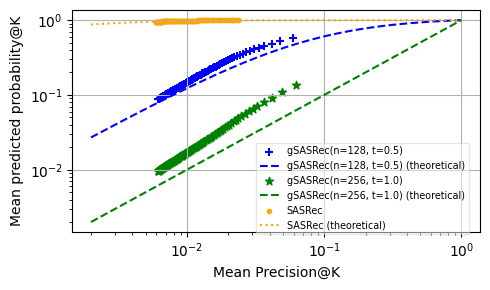

In [60]:
xs = np.linspace(0.002, 1, 2000)
gsas256_theoretical = [get_expected_pred(x, 256, 1) for x in xs]
gsas128_theoretical = [get_expected_pred(x, 128, 0.5) for x in xs]
sas_theoretical = [get_expected_pred(x, 1, 0) for x in xs]

N=100
plt.figure(figsize=(5,3))
plt.scatter(rank_rel_cnt_gsas128[:N], rank_sum_gsas128[:N], color='blue', marker='+', label='gSASRec(n=128, t=0.5)')
plt.plot(xs, gsas128_theoretical, color='blue', linestyle='dashed', label='gSASRec(n=128, t=0.5) (theoretical)')

plt.scatter(rank_rel_cnt_gsas256[:N], rank_sum_gsas256[:N], color='green', marker='*', label='gSASRec(n=256, t=1.0)')
plt.plot(xs, gsas256_theoretical, color='green',linestyle='dashed', label='gSASRec(n=256, t=1.0) (theoretical)')

plt.scatter(rank_rel_cnt_sas[:N], rank_sum_sas[:N], color='orange', marker='.', label='SASRec')
plt.plot(xs, sas_theoretical, color='orange', linestyle='dotted',  label='SASRec (theoretical)')

plt.yscale('log')
plt.xscale('log')


plt.xlabel('Mean Precision@K')
plt.ylabel('Mean predicted probability@K')
plt.tight_layout()
plt.legend(loc=(0.45, -0.01), framealpha=0.5, fontsize="x-small")
plt.grid()
plt.savefig("precision_pred_ml1m.pdf")
#plt.savefig("precision_pred_steam.pdf")

In [62]:
rank_sum_gsas256

array([0.13690789, 0.10844337, 0.09160308, ..., 0.00036015, 0.00036004,
       0.00035994])